### **"Social Distancing Detection for COVID-19 using Deep Learning"**

**Contributed by:**
**Divyanshi Bhojak and  Tarushi Jat**

---



### **Imports**

In [2]:
import smtplib, ssl
import cv2
import numpy as np
from math import sqrt
import numpy as np
import cv2
import matplotlib.pyplot as plt
from math import sqrt
import sys

### **Class for Sending ALERT Mails**

In [3]:
class Mailer:

    def __init__(self):
        self.EMAIL = "entre-sender-mail-id"
        self.PASS = "enter-password"
        self.PORT = 465
        self.server = smtplib.SMTP_SSL('smtp.gmail.com', self.PORT)

    def send(self, mail):
        self.server = smtplib.SMTP_SSL('smtp.gmail.com', self.PORT)
        self.server.login(self.EMAIL, self.PASS)
        SUBJECT = 'ALERT!'
        TEXT = f'Social distancing violations exceeded!'
        message = 'Subject: {}\n\n{}'.format(SUBJECT, TEXT)
        self.server.sendmail(self.EMAIL, mail, message)
        self.server.quit()

### **Different Useful Methods for this Project**

In [4]:
img = []
ix,iy = 0,0

def draw_circle(event,x,y,flags,param):
    global ix,iy
    if event == cv2.EVENT_LBUTTONDBLCLK:
        cv2.circle(img,(x,y),2,(255,0,0),-1)
        ix,iy = x,y

def get_points(image,numOfPoints, image_size=(800,800)):
    global img
    img = image.copy()
    img = cv2.resize(img,image_size)
    width, height = image.shape[:2]
    cv2.namedWindow("image")
    cv2.setMouseCallback("image",draw_circle)
    points = []
    print("Press a for add point : ")
    while len(points) != numOfPoints:
        cv2.imshow("image",img)
        k = cv2.waitKey(1)
        if k == ord('a'):
            points.append([int(ix),int(iy)])
            cv2.circle(img,(ix,iy),3,(0,0,255),-1)
    cv2.destroyAllWindows()
    return np.float32(points)

def create_model(config, weights):

    model = cv2.dnn.readNetFromDarknet(config, weights)
    backend = cv2.dnn.DNN_BACKEND_OPENCV
    target = cv2.dnn.DNN_TARGET_CPU
    model.setPreferableBackend(backend)
    model.setPreferableTarget(target)
    return model

def get_output_layers(model):

    layer_names = model.getLayerNames()
    output_layers = [layer_names[i[0]-1] for i in model.getUnconnectedOutLayers()]
    return output_layers

def blob_from_image(image, target_size):

    blob = cv2.dnn.blobFromImage(image, 1/255., target_size, [0,0,0], 1, crop=False)  
    return blob

def predict(blob, model, output_layers):

    model.setInput(blob)
    outputs = model.forward(output_layers)
    return outputs

def get_image_boxes(outputs, image_width, image_height, classes, confidence_threshold=0.5, nms_threshold=0.4):
    class_ids = []
    confidences = []
    boxes = []
    for output in outputs:
        for detection in output:
            scores = detection[5:]
            class_id = np.argmax(scores)
            class_name = classes[class_id]
            confidence = scores[class_id]
            if confidence > confidence_threshold and class_name== 'person':
                cx, cy, width, height = (detection[0:4] * np.array([image_width, image_height, image_width, image_height])).astype("int")
                x = int(cx - width / 2)
                y = int(cy - height / 2)
                boxes.append([x, y, int(width), int(height),cx,cy])
                confidences.append(float(confidence))
    nms_indices = cv2.dnn.NMSBoxes(boxes, confidences, confidence_threshold, nms_threshold)
    
    return [boxes[ind] for ind in nms_indices.flatten()]

def get_image_boxes2(outputs, image_width, image_height, classes, confidence_threshold=0.5, nms_threshold=0.4):
    class_ids = []
    confidences = []
    boxes = []
    total_conf = 0.0
    all_conf = 0.0
    count = 0
    for output in outputs:
        for detection in output:
            scores = detection[5:]
            class_id = np.argmax(scores)
            class_name = classes[class_id]
            confidence = scores[class_id]
            if class_name== 'person':
              #print("All conf :", confidence)
              all_conf = all_conf + confidence
            if confidence > confidence_threshold and class_name== 'person':
                cx, cy, width, height = (detection[0:4] * np.array([image_width, image_height, image_width, image_height])).astype("int")
                x = int(cx - width / 2)
                y = int(cy - height / 2)
                boxes.append([x, y, int(width), int(height),cx,cy])
                confidences.append(float(confidence))
                total_conf = total_conf + confidence
                #print("Confidence : ", confidence) 
                count = count + 1
    nms_indices = cv2.dnn.NMSBoxes(boxes, confidences, confidence_threshold, nms_threshold)
    
    return [boxes[ind] for ind in nms_indices.flatten()], total_conf, all_conf, count


def compute_point_perspective_transformation(matrix,boxes):
    list_downoids = [[box[4], box[5]+box[3]//2] for box in boxes]
    list_points_to_detect = np.float32(list_downoids).reshape(-1, 1, 2)
    transformed_points = cv2.perspectiveTransform(list_points_to_detect, matrix)
    transformed_points_list = list()
    for i in range(0,transformed_points.shape[0]):
        transformed_points_list.append([transformed_points[i][0][0],transformed_points[i][0][1]])
    return np.array(transformed_points_list).astype('int')

def get_red_green_boxes(distance_allowed,birds_eye_points,boxes):
    red_boxes = []
    green_boxes = []

    new_boxes = [tuple(box) + tuple(result) for box, result in zip(boxes, birds_eye_points)]
    for i in range(0, len(new_boxes)-1):
            for j in range(i+1, len(new_boxes)):
                cxi,cyi = new_boxes[i][6:]
                cxj,cyj = new_boxes[j][6:]
                distance = eucledian_distance([cxi,cyi], [cxj,cyj])
                if distance < distance_allowed:
                    red_boxes.append(new_boxes[i])
                    red_boxes.append(new_boxes[j])

    green_boxes = list(set(new_boxes) - set(red_boxes))
    red_boxes = list(set(red_boxes))
    return (green_boxes, red_boxes)

def eucledian_distance(point1, point2):
    x1,y1 = point1
    x2,y2 = point2
    return sqrt((x1-x2)**2 + (y1-y2)**2)

def get_birds_eye_view_image(green_box, red_box,eye_view_height,eye_view_width):
    blank_image = cv2.imread('/content/sample_data/black_background.png')
    
    cv2.putText(blank_image, str(len(red_box)), (120,100), cv2.FONT_HERSHEY_SIMPLEX , 2, (0,0,255), 4, cv2.LINE_AA) 
    cv2.putText(blank_image, str(len(green_box)), (520,100), cv2.FONT_HERSHEY_SIMPLEX , 2, (0,255,0), 4, cv2.LINE_AA)
    
    for point in green_box:
        cv2.circle(blank_image,tuple([point[6],point[7]]),20,(0,255,0),-1)
    for point in red_box:
        cv2.circle(blank_image,tuple([point[6],point[7]]),20,(0,0,255),-1)
    
    blank_image = cv2.resize(blank_image,(eye_view_width,eye_view_height))
      
    
    return blank_image

def get_red_green_box_image(new_box_image,green_box,red_box):
    for point in green_box:
        cv2.rectangle(new_box_image,(point[0],point[1]),(point[0]+point[2],point[1]+point[3]),(0, 255, 0), 2)
    for point in red_box:
        cv2.rectangle(new_box_image,(point[0],point[1]),(point[0]+point[2],point[1]+point[3]),(0, 0, 255), 2)
    return new_box_image

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
cd /content/drive/My Drive/Colab Notebooks/Social-Distance-IIC

[Errno 2] No such file or directory: '/content/drive/My Drive/Colab Notebooks/Social-Distance-IIC'
/content


### **Selecting Image**

In [6]:
original_image_BGR = cv2.imread('/content/sample_data/MOT20_02_raw_frame_100.jpg')
original_image_RGB = cv2.cvtColor(original_image_BGR, cv2.COLOR_BGR2RGB)
main_header = cv2.imread('/content/sample_data/main_header.jpg')

image_width = original_image_RGB.shape[1]
image_height = original_image_RGB.shape[0]

original_image_BGR_copy = original_image_BGR.copy()
original_image_RGB_copy = original_image_RGB.copy()

print('image Shape', original_image_RGB.shape)

image Shape (540, 960, 3)


### **Selecting Points for Perspective Transform**

In [7]:
# For Select Manualy 
# source_points = get_points(original_image_BGR_copy, 4, image_size=(image_width,image_height))

# points for TownCenter.mp4 or TownCenter_frames and pedestrians.avi or pedestrians_frames
#source_points = np.float32([[ 796.,  180.],
  #                           [1518.,  282.],
   #                          [1080.,  719.],
    #                         [ 128.,  480.]])

# points for pedestrianWalking.mp4 or pedestrianWalking_frames
# source_points = np.float32([[361., 212.],
#                             [673., 248.],
#                             [597., 338.],
#                             [265., 286.]])

#points for Student_video.mp4 or Student_video_frames
#source_points = np.float32([[ 141.,  546.],
 #                           [ 695.,  449.],
  #                          [1014.,  519.],
   #                         [ 437.,  692.]])


# points for MOT20_02_raw.mp4 or MOT20_02_raw_frames
source_points = np.float32([[142., 298.],
                           [784., 315.],
                           [811., 371.],
                           [ 82., 347.]])


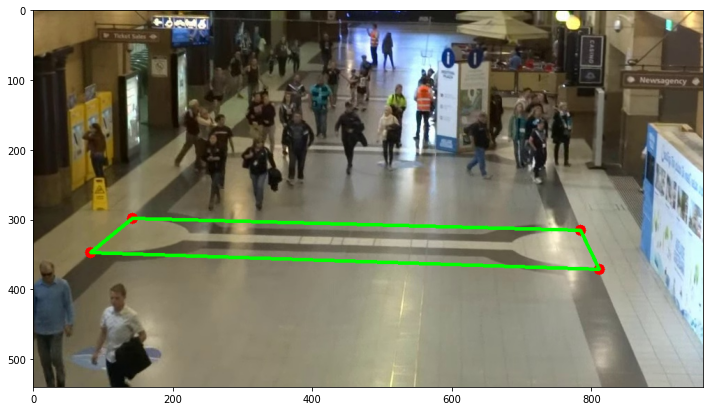

In [8]:
for point in source_points:
    cv2.circle(original_image_RGB_copy, tuple(point), 8, (255, 0, 0), -1)

points = source_points.reshape((-1,1,2)).astype(np.int32)
cv2.polylines(original_image_RGB_copy, [points], True, (0,255,0), thickness=4)

plt.figure(figsize=(12, 12))
plt.imshow(original_image_RGB_copy)
plt.show()

### **perspective transform matrix**

In [9]:
src=source_points

# destination points for Towncenter.mp4 or TownCenter_frames
# dst=np.float32([(0.1,0.5), (0.69, 0.5), (0.69,0.8), (0.1,0.8)])

# destination points for  pedestrianWalking.mp4 or pedestrianWalking_frames
# dst=np.float32([(0.49,0.5), (0.77, 0.5), (0.77,0.65), (0.49,0.65)])

# destination points for  Student_video.mp4 or Student_video_frames
# dst=np.float32([(0.1,0.8), (0.37, 0.8), (0.37,0.90), (0.1,0.90)])

# destination points for  MOT20_02_raw.mp4 or MOT20_02_raw_frames
dst=np.float32([(0.2,0.82), (0.80, 0.82), (0.80,0.87), (0.2,0.87)])

dst_size=(800,1080)
dst = dst * np.float32(dst_size)

H_matrix = cv2.getPerspectiveTransform(src, dst)
print("The perspective transform matrix:")
print(H_matrix)

The perspective transform matrix:
[[ 4.64100594e+00  8.20914118e+00 -2.16714663e+03]
 [ 8.94136789e-02  2.14071423e+01 -1.19908691e+03]
 [ 3.12807115e-04  1.61722589e-02  1.00000000e+00]]


### **Getting warpPerspective Image (TOP View)**

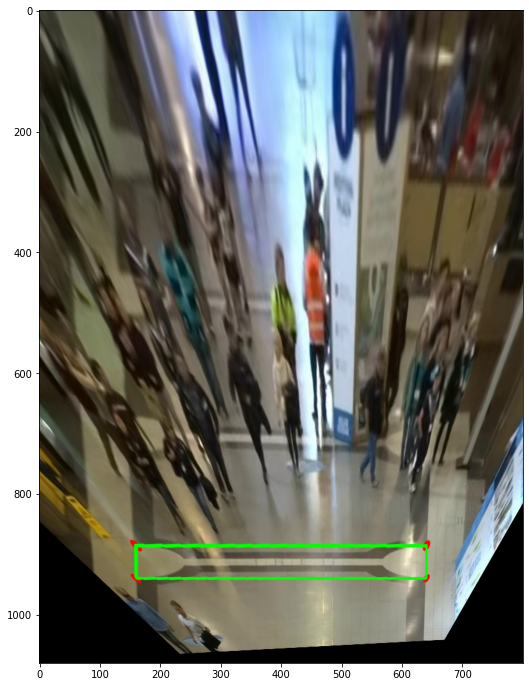

In [10]:
warped = cv2.warpPerspective(original_image_RGB_copy, H_matrix, dst_size)

plt.figure(figsize=(12, 12))
plt.imshow(warped)
plt.show()

### **YOLO model with weights and set parameters**

In [ ]:
!pip install opencv-contrib-python==3.4.13.47 --force-reinstall

     |████████████████████████████████| 53.7MB 82kB/s 
     |████████████████████████████████| 15.3MB 295kB/s 
ERROR: tensorflow 2.5.0 has requirement numpy~=1.19.2, but you'll have numpy 1.20.3 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [ ]:
confidence_threshold = 0.5
nms_threshold = 0.4

min_distance = 60
width = 608
height = 608

config = '/content/drive/MyDrive/YOLOv4/yolov4.cfg'
weights = '/content/drive/MyDrive/YOLOv4/yolov4.weights'
classes = '/content/drive/MyDrive/YOLOv4/coco.names'

with open(classes, 'rt') as f:
    coco_classes = f.read().strip('\n').split('\n')

model = create_model(config, weights)
output_layers = get_output_layers(model)

### **prediction with YOLO**

In [ ]:
blob = blob_from_image(original_image_RGB, (width, height))
outputs = predict(blob, model, output_layers)

### **Getting Detected Person Boxes**

In [ ]:
boxes = get_image_boxes(outputs, image_width, image_height, coco_classes)

### **Getting Points as Birds Eye View**

In [ ]:
birds_eye_points = compute_point_perspective_transformation(H_matrix, boxes)

### **Getting Red and Green Box Cordinates**

In [ ]:
green_box, red_box = get_red_green_boxes(min_distance, birds_eye_points, boxes)

### **Generating Birds-Eye-View Image**

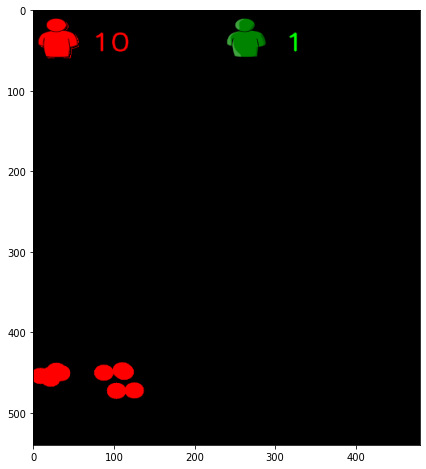

In [ ]:
birds_eye_view_image = get_birds_eye_view_image(green_box, red_box,eye_view_height=image_height,eye_view_width=image_width//2)
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(birds_eye_view_image, cv2.COLOR_RGB2BGR))
plt.show()

### **Drawing red and green boxes on detected Human**

In [ ]:
combined_image = np.concatenate((birds_eye_view_image,box_red_green_image), axis=1)
main_header = cv2.resize(main_header,(combined_image.shape[1],main_header.shape[0]))
deshboard_image  = np.concatenate((main_header,combined_image), axis=0)
plt.figure(figsize=(25, 20))
plt.imshow(cv2.cvtColor(deshboard_image, cv2.COLOR_RGB2BGR))
plt.show()

### **Combine both image horizontally and template**

In [ ]:
combined_image = np.concatenate((birds_eye_view_image,box_red_green_image), axis=1)
main_header = cv2.resize(main_header,(combined_image.shape[1],main_header.shape[0]))
deshboard_image  = np.concatenate((combined_image), axis=0)
plt.figure(figsize=(25, 20))
plt.imshow(cv2.cvtColor(combined_image, cv2.COLOR_RGB2BGR))
plt.show()

NameError: ignored

### **Social Distancing Detecting on input Video**

In [ ]:
#%%time
video_conf_score = 0
video = cv2.VideoCapture('/content/drive/MyDrive/Projects/YOLOv3/Results/MOT20-02-raw.webm')
writer = None
frame_number = 0
print('%-20s%-26s%-26s%-26s' % ('Processing Frame','|Total Detected Person','|Red Markerd Person','|Green Marked Person''|Confidence Score'))
while True:
  
  ret,frame = video.read()

  if not ret:
    break

  image_height, image_width = frame.shape[:2]

  image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
  blob = blob_from_image(image, (width, height))
  outputs = predict(blob, model, output_layers)

  boxes, total_conf, all_conf, count = get_image_boxes2(outputs, image_width, image_height, coco_classes)
  birds_eye_points = compute_point_perspective_transformation(H_matrix, boxes)
  green_box, red_box = get_red_green_boxes(min_distance, birds_eye_points,boxes)
  birds_eye_view_image = get_birds_eye_view_image(green_box, red_box, eye_view_height=image_height,eye_view_width=image_width//2)
  box_red_green_image = get_red_green_box_image(frame.copy(), green_box,red_box)

  combined_image = np.concatenate((birds_eye_view_image,box_red_green_image), axis=1)
  main_header = cv2.resize(main_header,(combined_image.shape[1],main_header.shape[0]))
  deshboard_image  = np.concatenate((main_header,combined_image), axis=0)

  frame_number += 1
  frame_avg_conf = total_conf/count
  sys.stdout.write('%-20i|%-25i|%-25i|%-25i|%-25f\n' % (frame_number,len(boxes),len(red_box),len(green_box), frame_avg_conf))
  video_conf_score = video_conf_score + frame_avg_conf 
  if len(red_box)>20:
			print("")
			print('[INFO] Sending mail...')
			Mailer().send("receiver-mail-id")
			print('[INFO] Mail sent')
  # if frame_number >=20:
  #   break

  if writer is None:
    fourcc = cv2.VideoWriter_fourcc(*"DIVX")
    writer = cv2.VideoWriter('/content/drive/MyDrive/YOLOv4/mot20.avi', fourcc, 15, (deshboard_image.shape[1], deshboard_image.shape[0]), True)

  writer.write(deshboard_image)

  del image,outputs,combined_image,deshboard_image,birds_eye_view_image

print(' ')
writer.release()
video.release()


Processing Frame    |Total Detected Person    |Red Markerd Person       |Green Marked Person|Confidence Score
1                   |14                       |14                       |0                        |0.758240                 
2                   |15                       |15                       |0                        |0.750406                 
3                   |14                       |14                       |0                        |0.751208                 
4                   |16                       |16                       |0                        |0.770466                 
5                   |14                       |13                       |1                        |0.725537                 
6                   |14                       |14                       |0                        |0.715013                 
7                   |16                       |16                       |0                        |0.682584                 
8              

### **Confidence Score**

In [ ]:
print("Confidence Score for the video = ",video_conf_score/frame_number)

Confidence Score for the video =  0.7503122930372382


### **See the output video in drive :]**